# VWBR (finra_buy_volume_z) Heatmap

Visualize FINRA buy volume z-scores across multiple ticker categories.

**Color scheme**: Purple (negative z) <- Black (neutral) -> Neon Green (positive z)

In [ ]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================

# Date range for heatmap
START_DATE = "2025-10-15"
END_DATE = "2026-01-05"

# Ticker Types: ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8", "SPECULATIVE", "CRYPTO"] or ["ALL"]
TICKER_TYPES = ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8"]

# View Mode: "indices" (main ETF/index only) or "constituents" (expand to holdings)
VIEW_MODE = "indices"  # or "constituents"

# Z-Scale Mode: "global" (vmin/vmax across all tickers) or "per_row" (vmin/vmax per ticker row)
Z_SCALE_MODE = "global"

# Cell size in inches (for square cells)
CELL_SIZE = 0.15

# Clustering options
ENABLE_CLUSTERING = False   # Toggle Y-axis clustering on/off
SHOW_DENDROGRAM = True      # Show dendrogram tree on left side of heatmap

# Cumulative flow subplot
SHOW_CUMULATIVE = True      # Show cumulative +/- z-score flow below heatmap
FLOW_POWER = 2.0            # Power for non-linear amplification (1.0 = linear, 2.0 = squared)

# =============================================================================
# IMPORTS
# =============================================================================

import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import importlib.util
from pathlib import Path
from datetime import datetime

# Clustering imports
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform

print("Configuration loaded.")

In [118]:
# =============================================================================
# CELL 2: TICKER DICTIONARY LOADING
# =============================================================================

def _load_ticker_dictionary():
    """Load ticker_dictionary.py dynamically from known locations."""
    candidates = [
        Path.cwd() / "ticker_dictionary.py",
        Path.cwd() / "Special_tools" / "ticker_dictionary.py",
        Path.cwd() / "darkpool" / "Special_tools" / "ticker_dictionary.py",
    ]
    
    for path in candidates:
        if path.exists():
            spec = importlib.util.spec_from_file_location("ticker_dictionary", path)
            if spec and spec.loader:
                module = importlib.util.module_from_spec(spec)
                spec.loader.exec_module(module)
                print(f"Loaded ticker dictionary from: {path}")
                return module
    raise FileNotFoundError(f"Could not find ticker_dictionary.py in: {candidates}")

# Load the module
ticker_dict = _load_ticker_dictionary()

# Extract data structures
SECTOR_ZOOM_MAP = getattr(ticker_dict, 'SECTOR_ZOOM_MAP', {})
SPECULATIVE_TICKERS = getattr(ticker_dict, 'SPECULATIVE_TICKERS', [])
CRYPTO_TICKERS = getattr(ticker_dict, 'CRYPTO_TICKERS', [])

# Mapping from user-friendly names to SECTOR_ZOOM_MAP keys
TYPE_TO_ZOOM_KEY = {
    "SECTOR": "SECTOR_CORE",
    "SUMMARY": "SECTOR_SUMMARY",
    "GLOBAL": "GLOBAL_MACRO",
    "COMMODITIES": "COMMODITIES",
    "MAG8": "MAG8",
}

# Synthetic parent tickers that don't exist as real tradeable tickers in the database
# These will always be expanded to constituents, even in "indices" mode
SYNTHETIC_PARENTS = {"MAG8"}

def build_ticker_list(ticker_types, view_mode):
    """
    Build list of tickers based on selected types and view mode.
    
    Returns:
        tickers: List of ticker symbols to query
        tickers_meta: Dict with category and parent info for each ticker
    """
    # Normalize "ALL" to full list
    if "ALL" in ticker_types:
        ticker_types = ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8", "SPECULATIVE", "CRYPTO"]
    
    tickers = []
    tickers_meta = {}  # ticker -> {category, parent, order}
    order = 0
    
    for ttype in ticker_types:
        if ttype in ["SPECULATIVE", "CRYPTO"]:
            # These are flat lists
            flat_list = SPECULATIVE_TICKERS if ttype == "SPECULATIVE" else CRYPTO_TICKERS
            for ticker in flat_list:
                if ticker not in tickers:
                    tickers.append(ticker)
                    tickers_meta[ticker] = {
                        "category": ttype,
                        "parent": None,
                        "order": order
                    }
                    order += 1
        elif ttype in TYPE_TO_ZOOM_KEY:
            zoom_key = TYPE_TO_ZOOM_KEY[ttype]
            if zoom_key in SECTOR_ZOOM_MAP:
                category_data = SECTOR_ZOOM_MAP[zoom_key]
                for parent_ticker, constituents in category_data.items():
                    # Check if this is a synthetic parent (not a real tradeable ticker)
                    is_synthetic = parent_ticker in SYNTHETIC_PARENTS
                    
                    if view_mode == "indices" and not is_synthetic:
                        # Real ETF/index - only add the parent ticker
                        if parent_ticker not in tickers:
                            tickers.append(parent_ticker)
                            tickers_meta[parent_ticker] = {
                                "category": ttype,
                                "parent": None,
                                "order": order
                            }
                            order += 1
                    else:
                        # Constituents mode OR synthetic parent - add all constituents
                        if not is_synthetic and parent_ticker not in tickers:
                            # Add real parent first (not for synthetic)
                            tickers.append(parent_ticker)
                            tickers_meta[parent_ticker] = {
                                "category": ttype,
                                "parent": None,
                                "is_parent": True,
                                "order": order
                            }
                            order += 1
                        # Add constituents
                        for constituent in constituents:
                            if constituent not in tickers:
                                tickers.append(constituent)
                                tickers_meta[constituent] = {
                                    "category": ttype,
                                    "parent": parent_ticker if not is_synthetic else f"({parent_ticker})",
                                    "is_parent": False,
                                    "order": order
                                }
                                order += 1
    
    print(f"Built ticker list: {len(tickers)} tickers from {ticker_types}")
    return tickers, tickers_meta

# Test
test_tickers, test_meta = build_ticker_list(TICKER_TYPES, VIEW_MODE)
print(f"Sample tickers: {test_tickers[:10]}...")

Loaded ticker dictionary from: c:\Users\fvign\Dropbox\Vscode\darkpool\Special_tools\ticker_dictionary.py
Built ticker list: 39 tickers from ['SECTOR', 'SUMMARY', 'GLOBAL', 'COMMODITIES', 'MAG8']
Sample tickers: ['XLF', 'KRE', 'XLK', 'SMH', 'XLI', 'XLY', 'XLE', 'XLV', 'XLP', 'XLU']...


In [119]:
# =============================================================================
# CELL 3: DATABASE CONNECTION
# =============================================================================

def get_db_path():
    """Find the darkpool.duckdb database using relative paths."""
    candidates = [
        Path.cwd() / "darkpool_analysis" / "data" / "darkpool.duckdb",
        Path.cwd().parent / "darkpool_analysis" / "data" / "darkpool.duckdb",
        Path.cwd() / ".." / "darkpool_analysis" / "data" / "darkpool.duckdb",
        Path.cwd() / "darkpool" / "darkpool_analysis" / "data" / "darkpool.duckdb",
    ]
    
    for path in candidates:
        resolved = path.resolve()
        if resolved.exists():
            return resolved
    
    raise FileNotFoundError(f"Could not find darkpool.duckdb in: {[str(p) for p in candidates]}")

def connect_db():
    """Connect to the DuckDB database in read-only mode."""
    db_path = get_db_path()
    print(f"Connecting to database: {db_path}")
    return duckdb.connect(str(db_path), read_only=True)

# Test connection
with connect_db() as conn:
    tables = conn.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'main'").fetchall()
    print(f"Available tables: {[t[0] for t in tables]}")

Connecting to database: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Available tables: ['composite_signal', 'daily_metrics', 'finra_otc_weekly_raw', 'finra_short_daily_raw', 'index_constituent_short_agg_daily', 'lit_direction_daily', 'options_premium_daily', 'options_premium_summary', 'polygon_daily_agg_raw', 'polygon_equity_trades_raw', 'polygon_ingestion_state']


In [120]:
# =============================================================================
# CELL 4: DATA FETCHING
# =============================================================================

def fetch_heatmap_data(conn, tickers, start_date, end_date):
    """
    Fetch finra_buy_volume_z data for specified tickers and date range.
    
    Returns:
        DataFrame with tickers as rows, dates as columns, values are finra_buy_volume_z
    """
    # Build parameterized query
    placeholders = ", ".join(["?" for _ in tickers])
    query = f"""
        SELECT date, symbol, finra_buy_volume_z
        FROM daily_metrics
        WHERE symbol IN ({placeholders})
          AND date BETWEEN ? AND ?
        ORDER BY date, symbol
    """
    
    params = list(tickers) + [start_date, end_date]
    result = conn.execute(query, params).fetchdf()
    
    if result.empty:
        print(f"Warning: No data found for tickers in date range {start_date} to {end_date}")
        return pd.DataFrame()
    
    # Pivot: rows=tickers, columns=dates
    pivot = result.pivot(index='symbol', columns='date', values='finra_buy_volume_z')
    
    # Reorder rows to match input ticker order
    available_tickers = [t for t in tickers if t in pivot.index]
    missing_tickers = [t for t in tickers if t not in pivot.index]
    if missing_tickers:
        print(f"Warning: {len(missing_tickers)} tickers not found in database: {missing_tickers[:5]}...")
    
    pivot = pivot.reindex(available_tickers)
    
    print(f"Fetched data: {pivot.shape[0]} tickers x {pivot.shape[1]} days")
    return pivot

# Test fetch
with connect_db() as conn:
    test_data = fetch_heatmap_data(conn, test_tickers, START_DATE, END_DATE)
    print(f"Data shape: {test_data.shape}")
    if not test_data.empty:
        print(f"Date range: {test_data.columns.min()} to {test_data.columns.max()}")

Connecting to database: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Fetched data: 39 tickers x 56 days
Data shape: (39, 56)
Date range: 2025-10-15 00:00:00 to 2026-01-05 00:00:00


In [121]:
# =============================================================================
# CELL 4b: DIAGNOSTIC - Check for null values in date range
# =============================================================================

def diagnose_missing_data(conn, tickers, start_date, end_date):
    """Check which dates/tickers have null finra_buy_volume_z values."""
    
    placeholders = ", ".join(["?" for _ in tickers])
    
    # Check null counts per date
    query_dates = f"""
        SELECT date, 
               COUNT(*) as total_tickers,
               SUM(CASE WHEN finra_buy_volume_z IS NULL THEN 1 ELSE 0 END) as null_count
        FROM daily_metrics
        WHERE symbol IN ({placeholders})
          AND date BETWEEN ? AND ?
        GROUP BY date
        ORDER BY date
        LIMIT 20
    """
    params = list(tickers) + [start_date, end_date]
    date_nulls = conn.execute(query_dates, params).fetchdf()
    
    print("=== Null counts per date (first 20 days) ===")
    print(date_nulls.to_string())
    
    # Check which tickers have nulls in the first week
    query_tickers = f"""
        SELECT symbol, 
               COUNT(*) as days,
               SUM(CASE WHEN finra_buy_volume_z IS NULL THEN 1 ELSE 0 END) as null_days
        FROM daily_metrics
        WHERE symbol IN ({placeholders})
          AND date BETWEEN ? AND DATE_ADD(CAST(? AS DATE), INTERVAL 7 DAY)
        GROUP BY symbol
        HAVING null_days > 0
        ORDER BY null_days DESC
    """
    params2 = list(tickers) + [start_date, start_date]
    ticker_nulls = conn.execute(query_tickers, params2).fetchdf()
    
    print("\n=== Tickers with nulls in first week ===")
    if ticker_nulls.empty:
        print("No tickers with null values in first week")
    else:
        print(ticker_nulls.to_string())
    
    return date_nulls, ticker_nulls

# Run diagnostic
with connect_db() as conn:
    diagnose_missing_data(conn, test_tickers, START_DATE, END_DATE)

Connecting to database: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
=== Null counts per date (first 20 days) ===
         date  total_tickers  null_count
0  2025-10-15             39         0.0
1  2025-10-16             39         0.0
2  2025-10-17             39         0.0
3  2025-10-20             39         0.0
4  2025-10-21             39         0.0
5  2025-10-22             39         0.0
6  2025-10-23             39         0.0
7  2025-10-24             39         0.0
8  2025-10-27             39         0.0
9  2025-10-28             39         0.0
10 2025-10-29             39         0.0
11 2025-10-30             39         0.0
12 2025-10-31             39         0.0
13 2025-11-03             39         0.0
14 2025-11-04             39         0.0
15 2025-11-05             39         0.0
16 2025-11-06             39         0.0
17 2025-11-07             39         0.0
18 2025-11-10             39         0.0
19 2025-11-11             39     

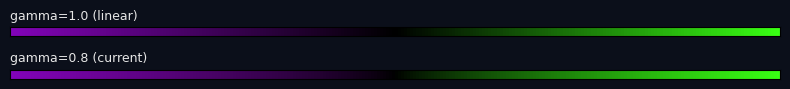

In [122]:
# =============================================================================
# CELL 5: COLOR MAPPING
# =============================================================================

# Dark theme colors
BG_COLOR = '#0b0f1a'
TEXT_COLOR = '#e6e6e6'
GRID_COLOR = '#2a2a3a'

# Diverging colormap: Purple <- Black -> Neon Green
PURPLE = '#8304B9'
BLACK = '#000000'
NEON_GREEN = '#39FF14'

def create_z_colormap(gamma=1.0):
    """
    Create diverging colormap for z-scores with gamma correction.
    
    Args:
        gamma: Power factor for non-linear scaling.
               gamma > 1: more contrast near extremes, subtle mid-tones
               gamma < 1: more contrast near center, compressed extremes
    """
    # Sample colors along linear gradient, then apply gamma to positions
    n_samples = 256
    colors = []
    
    for i in range(n_samples):
        # Linear position [0, 1]
        t = i / (n_samples - 1)
        
        # Apply gamma correction (centered at 0.5)
        if t < 0.5:
            # Negative side: map [0, 0.5] with gamma
            t_adj = 0.5 - (0.5 - t) ** gamma / (0.5 ** (gamma - 1))
        elif t > 0.5:
            # Positive side: map [0.5, 1] with gamma
            t_adj = 0.5 + (t - 0.5) ** gamma / (0.5 ** (gamma - 1))
        else:
            t_adj = 0.5
        
        t_adj = max(0, min(1, t_adj))
        
        # Interpolate color: Purple -> Black -> Green
        if t_adj < 0.5:
            # Purple to Black
            ratio = t_adj / 0.5
            r = int(0x83 * (1 - ratio))
            g = int(0x04 * (1 - ratio))
            b = int(0xB9 * (1 - ratio))
        else:
            # Black to Green
            ratio = (t_adj - 0.5) / 0.5
            r = int(0x39 * ratio)
            g = int(0xFF * ratio)
            b = int(0x14 * ratio)
        
        colors.append(f'#{r:02x}{g:02x}{b:02x}')
    
    return LinearSegmentedColormap.from_list('z_diverging', colors, N=256)

# Gamma=0.8 expands mid-range colors, making subtle z-scores more visible
Z_CMAP = create_z_colormap(gamma=0.8)

def normalize_data(data, z_scale_mode):
    """
    Normalize z-score data for colormap application.
    """
    values = data.values.copy()
    
    if z_scale_mode == "global":
        abs_max = np.nanmax(np.abs(values))
        if abs_max > 0:
            normalized = values / abs_max
        else:
            normalized = values
        vmin, vmax = -abs_max, abs_max
        
    elif z_scale_mode == "per_row":
        normalized = np.zeros_like(values)
        for i in range(values.shape[0]):
            row = values[i, :]
            row_abs_max = np.nanmax(np.abs(row))
            if row_abs_max > 0:
                normalized[i, :] = row / row_abs_max
            else:
                normalized[i, :] = 0
        vmin, vmax = -1, 1
    else:
        raise ValueError(f"Unknown z_scale_mode: {z_scale_mode}")
    
    return pd.DataFrame(normalized, index=data.index, columns=data.columns), vmin, vmax

# Test colormap comparison
fig, axes = plt.subplots(2, 1, figsize=(8, 1))
fig.patch.set_facecolor(BG_COLOR)
gradient = np.linspace(-1, 1, 256).reshape(1, -1)

axes[0].imshow(gradient, aspect='auto', cmap=create_z_colormap(gamma=1.0))
axes[0].set_title('gamma=1.0 (linear)', color=TEXT_COLOR, fontsize=9, loc='left')
axes[0].set_yticks([]); axes[0].set_xticks([])

axes[1].imshow(gradient, aspect='auto', cmap=Z_CMAP)
axes[1].set_title('gamma=0.8 (current)', color=TEXT_COLOR, fontsize=9, loc='left')
axes[1].set_yticks([]); axes[1].set_xticks([])

plt.tight_layout()
plt.show()

In [123]:
# =============================================================================
# CELL 5b: HIERARCHICAL CLUSTERING FUNCTIONS
# =============================================================================

def compute_correlation_distance(data):
    """
    Compute correlation-based distance matrix.
    Distance = 1 - Pearson correlation (range: 0 to 2)
    """
    # Handle NaN values by filling with row mean
    row_means = data.mean(axis=1)
    clean_data = data.T.fillna(row_means).T
    
    # Compute correlation matrix (ticker-to-ticker)
    corr_matrix = clean_data.T.corr()
    
    # Convert to distance: d = 1 - correlation
    dist_matrix = 1 - corr_matrix
    
    # Ensure diagonal is 0 and matrix is symmetric
    np.fill_diagonal(dist_matrix.values, 0)
    
    return dist_matrix

def cluster_within_categories(data, tickers_meta):
    """
    Apply hierarchical clustering within each category block.
    
    Args:
        data: DataFrame (tickers x dates) with z-scores
        tickers_meta: Dict with category info for each ticker
        
    Returns:
        clustered_order: List of ticker symbols in new order
        linkage_by_category: OrderedDict of {category: (Z, tickers)} for dendrograms
    """
    from collections import OrderedDict
    
    clustered_order = []
    linkage_by_category = OrderedDict()
    
    # Group tickers by category, preserving order
    category_groups = OrderedDict()
    for ticker in data.index:
        meta = tickers_meta.get(ticker, {})
        cat = meta.get('category', 'UNKNOWN')
        if cat not in category_groups:
            category_groups[cat] = []
        category_groups[cat].append(ticker)
    
    # Cluster each category independently
    for category, tickers in category_groups.items():
        if len(tickers) <= 2:
            # Too few tickers to cluster meaningfully
            clustered_order.extend(tickers)
            linkage_by_category[category] = None
            continue
        
        # Extract subset for this category
        subset = data.loc[tickers]
        
        # Compute distance matrix
        dist_matrix = compute_correlation_distance(subset)
        
        # Convert to condensed form for scipy
        condensed_dist = squareform(dist_matrix.values, checks=False)
        
        # Handle potential NaN/inf values
        condensed_dist = np.nan_to_num(condensed_dist, nan=1.0, posinf=2.0, neginf=0.0)
        
        # Ensure non-negative distances
        condensed_dist = np.clip(condensed_dist, 0, 2)
        
        # Perform hierarchical clustering (average linkage works well for correlation)
        Z = linkage(condensed_dist, method='average')
        
        # Get optimal leaf ordering
        leaf_order = leaves_list(Z)
        
        # Reorder tickers
        reordered = [tickers[i] for i in leaf_order]
        clustered_order.extend(reordered)
        linkage_by_category[category] = (Z, reordered)
    
    return clustered_order, linkage_by_category

print("Clustering functions defined.")

Clustering functions defined.


In [ ]:
# =============================================================================
# CELL 7-8: MAIN HEATMAP RENDERING WITH CUMULATIVE FLOW
# =============================================================================

def draw_stacked_dendrograms(ax, linkage_by_category, tickers_meta, data_index):
    """
    Draw multiple dendrograms stacked vertically, aligned with heatmap rows.
    """
    ax.set_facecolor(BG_COLOR)
    
    current_y_offset = 0
    max_x = 0
    
    for category, cat_data in linkage_by_category.items():
        cat_tickers = [t for t in data_index if tickers_meta.get(t, {}).get('category') == category]
        n_cat = len(cat_tickers)
        
        if cat_data is None or n_cat <= 2:
            current_y_offset += n_cat
            continue
        
        Z, reordered_tickers = cat_data
        dendro_data = dendrogram(Z, orientation='left', no_plot=True)
        
        icoord = dendro_data['icoord']
        dcoord = dendro_data['dcoord']
        
        for ic, dc in zip(icoord, dcoord):
            y_coords = [(y - 5) / 10 + current_y_offset for y in ic]
            ax.plot(dc, y_coords, color=TEXT_COLOR, linewidth=0.7)
            max_x = max(max_x, max(dc))
        
        current_y_offset += n_cat
    
    ax.set_xlim(max_x * 1.1, 0)
    ax.set_yticks([])
    ax.set_xticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

def calculate_cumulative_flow(data, power=1.0):
    """
    Calculate cumulative positive and negative z-score flows with non-linear amplification.
    
    Args:
        data: DataFrame with z-scores (tickers x dates)
        power: Exponent for non-linear amplification
               1.0 = linear (z=3 contributes 3x more than z=1)
               2.0 = squared (z=3 contributes 9x more than z=1)
               
    With power > 1, extreme z-scores are amplified relative to mild ones.
    """
    # Apply sign-preserving power transformation: sign(z) * |z|^power
    # This amplifies extreme values while preserving direction
    amplified = np.sign(data) * np.abs(data) ** power
    
    # Sum amplified z-scores per day
    daily_positive = amplified.apply(lambda col: col[col > 0].sum(), axis=0).fillna(0)
    daily_negative = amplified.apply(lambda col: col[col < 0].sum(), axis=0).fillna(0)
    
    # Cumulative sums
    cum_positive = daily_positive.cumsum()
    cum_negative = daily_negative.cumsum()
    cum_net = (daily_positive + daily_negative).cumsum()
    
    return cum_positive, cum_negative, cum_net

def plot_vwbr_heatmap(data, tickers_meta, z_scale_mode, view_mode, cell_size=0.15,
                       show_dendrogram=False, linkage_by_category=None, 
                       show_cumulative=True, flow_power=1.0):
    """
    Main heatmap plotting function with optional dendrogram and cumulative flow.
    """
    if data.empty:
        print("No data to plot!")
        return None
    
    n_tickers, n_days = data.shape
    normalized_data, vmin, vmax = normalize_data(data, z_scale_mode)
    
    # Calculate figure size
    plot_width = n_days * cell_size
    plot_height = n_tickers * cell_size
    cumulative_height = 1.8 if show_cumulative else 0
    
    # Margins
    left_margin = 1.0 if not show_dendrogram else 0.3
    right_margin = 1.5
    top_margin = 1.2
    bottom_margin = 1.8 if show_cumulative else 1.5
    dendro_width = 1.5 if show_dendrogram else 0
    
    fig_width = plot_width + left_margin + right_margin + dendro_width
    fig_height = plot_height + top_margin + bottom_margin + cumulative_height
    fig_width = max(fig_width, 10)
    fig_height = max(fig_height, 6)
    
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.patch.set_facecolor(BG_COLOR)
    
    # Calculate layout proportions
    if show_cumulative:
        heat_height_frac = 0.54
        cum_height_frac = 0.18
        gap = 0.02
        bottom_heat = 0.12 + cum_height_frac + gap + 0.06
        bottom_cum = 0.10
    else:
        heat_height_frac = 0.72
        cum_height_frac = 0
        gap = 0
        bottom_heat = 0.15
        bottom_cum = 0
    
    # Define consistent widths for alignment
    if show_dendrogram and linkage_by_category:
        dendro_left = 0.02
        dendro_width_frac = 0.08
        heat_left = dendro_left + dendro_width_frac + 0.02
        heat_width = 0.72
    else:
        heat_left = 0.10
        heat_width = 0.78
    
    # Create axes
    if show_dendrogram and linkage_by_category:
        ax_dendro = fig.add_axes([dendro_left, bottom_heat, dendro_width_frac, heat_height_frac])
        ax_dendro.set_facecolor(BG_COLOR)
    else:
        ax_dendro = None
    
    ax_heat = fig.add_axes([heat_left, bottom_heat, heat_width, heat_height_frac])
    ax_heat.set_facecolor(BG_COLOR)
    
    if show_cumulative:
        ax_cum = fig.add_axes([heat_left, bottom_cum, heat_width, cum_height_frac])
        ax_cum.set_facecolor(BG_COLOR)
    
    # Plot heatmap
    im = ax_heat.imshow(
        normalized_data.values,
        aspect='equal',
        cmap=Z_CMAP,
        vmin=-1,
        vmax=1,
        interpolation='nearest'
    )
    
    ax_heat.set_yticks(np.arange(n_tickers))
    
    # Build category boundaries
    category_boundaries = []
    prev_category = None
    y_labels = []
    
    for i, ticker in enumerate(data.index):
        meta = tickers_meta.get(ticker, {})
        category = meta.get('category', '')
        parent = meta.get('parent', None)
        is_parent = meta.get('is_parent', False)
        
        if category != prev_category:
            category_boundaries.append(i - 0.5)
            prev_category = category
        
        if view_mode == "constituents":
            if is_parent:
                y_labels.append(f">> {ticker}")
            elif parent:
                y_labels.append(f"   {ticker}")
            else:
                y_labels.append(ticker)
        else:
            y_labels.append(ticker)
    
    ax_heat.set_yticklabels(y_labels, fontsize=7 if view_mode == "constituents" else 8, 
                            color=TEXT_COLOR, fontfamily='monospace' if view_mode == "constituents" else None)
    
    for boundary in category_boundaries[1:]:
        ax_heat.axhline(y=boundary, color=GRID_COLOR, linewidth=1.5, linestyle='-')
    
    # X-axis setup
    dates = data.columns
    if n_days > 100:
        step = n_days // 20
    elif n_days > 50:
        step = n_days // 10
    else:
        step = max(1, n_days // 10)
    
    x_ticks = np.arange(0, n_days, step)
    date_labels = []
    for idx in x_ticks:
        if idx < len(dates):
            d = dates[idx]
            if hasattr(d, 'strftime'):
                date_labels.append(d.strftime('%m/%d'))
            else:
                date_labels.append(str(d)[-5:])
        else:
            date_labels.append('')
    
    ax_heat.set_xticks(x_ticks)
    ax_heat.set_xticklabels(date_labels, rotation=45, ha='right', fontsize=7, color=TEXT_COLOR)
    ax_heat.set_xlabel('Date', color=TEXT_COLOR, fontsize=10)
    
    # Colorbar
    cbar_ax = fig.add_axes([heat_left + heat_width + 0.02, bottom_heat, 0.015, heat_height_frac])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR)
    cbar.outline.set_edgecolor(GRID_COLOR)
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color=TEXT_COLOR, fontsize=8)
    
    if z_scale_mode == "global":
        cbar.set_label(f'Z', color=TEXT_COLOR, fontsize=9)
    else:
        cbar.set_label('Z (per-row)', color=TEXT_COLOR, fontsize=9)
    
    # Draw dendrograms
    if ax_dendro is not None and linkage_by_category:
        ax_dendro.set_ylim(n_tickers - 0.5, -0.5)
        draw_stacked_dendrograms(ax_dendro, linkage_by_category, tickers_meta, data.index)
        
        for boundary in category_boundaries[1:]:
            ax_dendro.axhline(y=boundary, color=GRID_COLOR, linewidth=1.5, linestyle='-')
    
    # Draw cumulative flow subplot
    if show_cumulative:
        cum_positive, cum_negative, cum_net = calculate_cumulative_flow(data, flow_power)
        
        x_vals = np.arange(len(cum_positive))
        
        # Plot positive cumulative (green)
        ax_cum.plot(x_vals, cum_positive.values, color='#39FF14', linewidth=1.5, label='Cum +Z')
        
        # Plot negative cumulative (red) - absolute value
        ax_cum.plot(x_vals, np.abs(cum_negative.values), color='#FF3939', linewidth=1.5, label='Cum -Z')
        
        # Plot net as filled area around zero (light grey)
        ax_cum.fill_between(x_vals, 0, cum_net.values, alpha=0.3, color='#888888', label='Net')
        ax_cum.axhline(y=0, color=GRID_COLOR, linewidth=0.8, linestyle='--')
        
        ax_cum.set_xlim(-0.5, n_days - 0.5)
        
        ax_cum.set_xticks(x_ticks)
        ax_cum.set_xticklabels(date_labels, rotation=45, ha='right', fontsize=7, color=TEXT_COLOR)
        ax_cum.set_xlabel('Date', color=TEXT_COLOR, fontsize=10)
        
        ax_cum.tick_params(axis='both', colors=TEXT_COLOR, labelsize=7)
        label_power = f' (z^{flow_power})' if flow_power != 1.0 else ''
        ax_cum.set_ylabel(f'Cum Z{label_power}', color=TEXT_COLOR, fontsize=8)
        
        ax_cum.legend(loc='upper left', fontsize=7, facecolor=BG_COLOR, edgecolor=GRID_COLOR,
                      labelcolor=TEXT_COLOR, framealpha=0.9)
        
        for spine in ax_cum.spines.values():
            spine.set_color(GRID_COLOR)
    
    # Title
    clustering_str = " (clustered)" if show_dendrogram else ""
    title = f'VWBR Z-Score Heatmap{clustering_str} | {data.columns.min()} to {data.columns.max()}'
    fig.suptitle(title, color=TEXT_COLOR, fontsize=12, y=0.995)
    
    ax_heat.set_ylabel('Ticker', color=TEXT_COLOR, fontsize=10)
    
    for spine in ax_heat.spines.values():
        spine.set_color(GRID_COLOR)
    
    ax_heat.tick_params(axis='both', colors=TEXT_COLOR)
    
    return fig

print("Heatmap function defined with cumulative flow subplot.")

In [ ]:
# =============================================================================
# CELL 9: EXECUTION
# =============================================================================

# Build ticker list
tickers, tickers_meta = build_ticker_list(TICKER_TYPES, VIEW_MODE)

# Connect and fetch data
with connect_db() as conn:
    data = fetch_heatmap_data(conn, tickers, START_DATE, END_DATE)

# Apply clustering if enabled
linkage_by_category = None
if ENABLE_CLUSTERING and not data.empty:
    print("Applying hierarchical clustering within categories...")
    clustered_order, linkage_by_category = cluster_within_categories(data, tickers_meta)
    
    # Reorder data by clustered order
    data = data.reindex(clustered_order)
    
    # Update tickers_meta order to match new ordering
    for i, ticker in enumerate(clustered_order):
        if ticker in tickers_meta:
            tickers_meta[ticker]['order'] = i
    
    print(f"Clustering complete. Categories clustered: {len([k for k,v in linkage_by_category.items() if v is not None])}")

# Plot heatmap
if not data.empty:
    fig = plot_vwbr_heatmap(
        data, 
        tickers_meta, 
        Z_SCALE_MODE, 
        VIEW_MODE, 
        CELL_SIZE,
        show_dendrogram=SHOW_DENDROGRAM and ENABLE_CLUSTERING,
        linkage_by_category=linkage_by_category,
        show_cumulative=SHOW_CUMULATIVE,
        flow_power=FLOW_POWER
    )
    plt.show()
else:
    print("No data available for the selected parameters.")

Built ticker list: 39 tickers from ['SECTOR', 'SUMMARY', 'GLOBAL', 'COMMODITIES', 'MAG8']
Connecting to database: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Fetched data: 39 tickers x 56 days


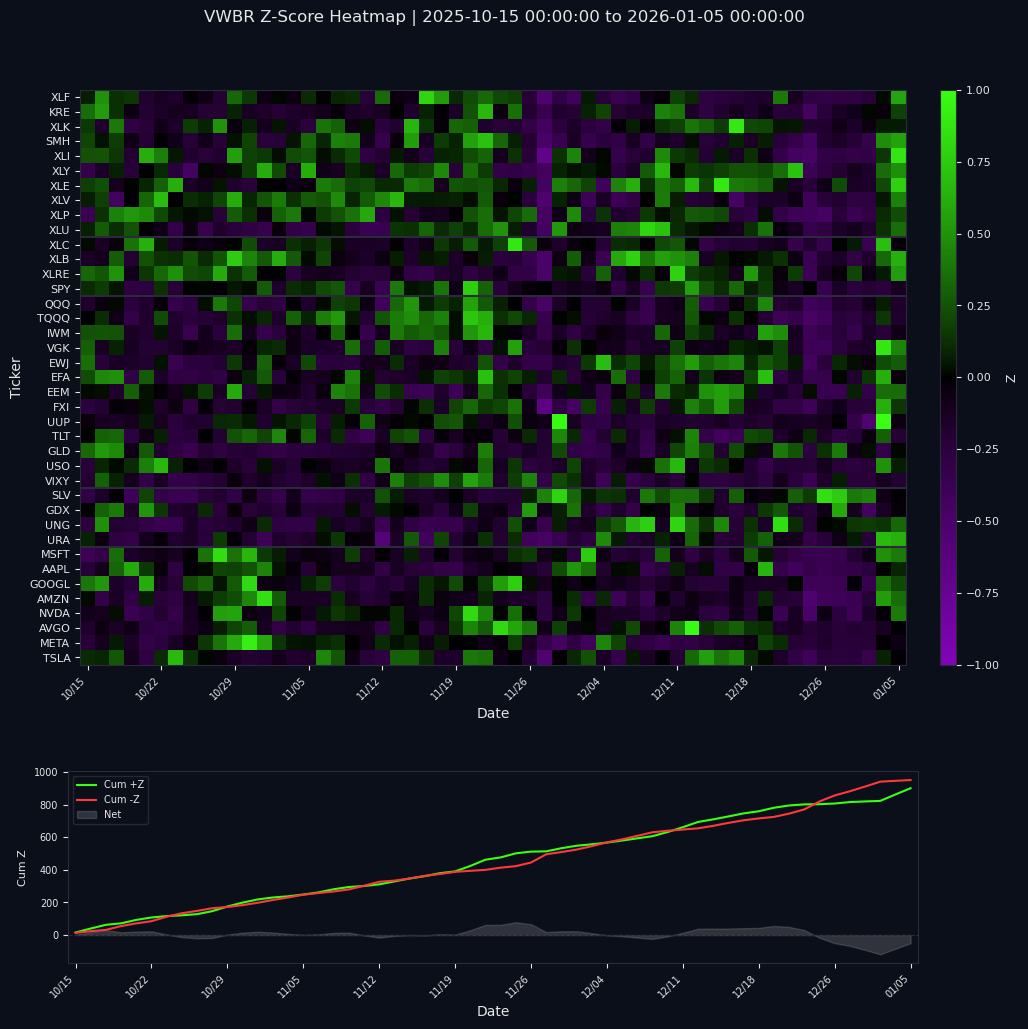

In [126]:
# =============================================================================
# CELL 9: EXECUTION
# =============================================================================

# Build ticker list
tickers, tickers_meta = build_ticker_list(TICKER_TYPES, VIEW_MODE)

# Connect and fetch data
with connect_db() as conn:
    data = fetch_heatmap_data(conn, tickers, START_DATE, END_DATE)

# Apply clustering if enabled
linkage_by_category = None
if ENABLE_CLUSTERING and not data.empty:
    print("Applying hierarchical clustering within categories...")
    clustered_order, linkage_by_category = cluster_within_categories(data, tickers_meta)
    
    # Reorder data by clustered order
    data = data.reindex(clustered_order)
    
    # Update tickers_meta order to match new ordering
    for i, ticker in enumerate(clustered_order):
        if ticker in tickers_meta:
            tickers_meta[ticker]['order'] = i
    
    print(f"Clustering complete. Categories clustered: {len([k for k,v in linkage_by_category.items() if v is not None])}")

# Plot heatmap
if not data.empty:
    fig = plot_vwbr_heatmap(
        data, 
        tickers_meta, 
        Z_SCALE_MODE, 
        VIEW_MODE, 
        CELL_SIZE,
        show_dendrogram=SHOW_DENDROGRAM and ENABLE_CLUSTERING,
        linkage_by_category=linkage_by_category
    )
    plt.show()
else:
    print("No data available for the selected parameters.")